In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('sab-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAAGCCCCACGGCGAGGCACTCTTGATCCCCACCTCAAGAGGT...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCTC...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 40196.93it/s]


[5, 15, 48, 85, 128, 169, 220, 254, 348, 374, 428, 501, 541, 590, 668, 723, 785, 836, 917, 974, 1031, 1081, 1162, 1216, 1287, 1395, 1431, 1495, 1566, 1657, 1679, 1811, 1875, 1936, 1994, 2076, 2137, 2188, 2228, 2333, 2352, 2409, 2522, 2561, 2611, 2736, 2751, 2811, 2840, 2915, 2951, 3029, 3112, 3165, 3265, 3245, 3115, 3133, 3125, 3023, 2970, 2905, 2818, 2816, 2735, 2631, 2540, 2486, 2465, 2355, 2275, 2297, 2178, 2107, 2109, 1995, 1923, 1864, 1813, 1728, 1653, 1568, 1518, 1425, 1393, 1326, 1209, 1158, 1091, 1027, 964, 881, 835, 778, 704, 650, 577, 528, 471, 396, 365, 334, 268, 218, 173, 126, 78, 35, 15, 0]


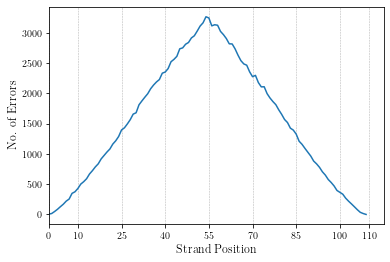

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov10-sab-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:07<00:00, 1301.14it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


CG -> T 6
CG -> AA 6
G -> AT 6
GAT -> C 6
 -> GAA 6
CGC ->  6
 -> TTA 6
 -> TCG 6
 -> TGC 6
TG -> AA 6
AGC ->  6
TT -> AG 6
AGA ->  6
A -> TC 6
GGA ->  6
CT -> AA 6
GT -> CA 6
GTA ->  6
CTA ->  6
CAA ->  6
T -> AAA 6
AAT ->  6
 -> GTG 6
C -> GA 7
 -> TAG 7
TGG ->  7
GT -> CC 7
CCT ->  7
TC -> AA 7
GC -> AT 7
G -> CT 7
 -> TTC 7
ATC ->  7
TCT ->  7
GCA ->  7
 -> TTT 7
AGG ->  7
CGT ->  7
 -> GGG 7
 -> GGT 7
A -> TT 7
GAG ->  7
 -> AGC 7
 -> GCT 8
 -> ATG 8
GTG ->  8
CAG ->  8
GT -> AA 8
 -> CCG 8
GG -> C 8
 -> GCA 8
 -> TGG 8
 -> CGT 8
 -> GAC 8
 -> CTT 8
 -> AGG 9
A -> GC 9
ATG ->  9
 -> GTT 9
A -> GT 9
TC -> GA 9
TA -> G 9
AG -> C 9
TGA ->  9
TAT ->  9
A -> GG 9
ACG ->  9
 -> AGT 9
 -> CTG 9
 -> CGC 9
 -> AAT 9
TT -> G 9
 -> CAG 9
GAT ->  9
 -> GGA 9
GGC ->  9
 -> CTA 9
 -> ACT 10
 -> GAT 10
G -> TA 10
 -> AAG 10
 -> TAC 10
 -> TCT 10
 -> TGA 10
TTC ->  10
GTT ->  10
GC -> T 10
TCA ->  11
CC -> A 11
GAC ->  11
 -> GCC 11
 -> GGC 11
 -> CAT 11
CTG ->  11
AC -> G 11
TGC ->  11
 -> GCG 1

 -> C @ 103 6
G -> T @ 26 6
C -> T @ 56 6
AT ->  @ 58 6
 -> A @ 96 6
 -> GA @ 58 6
 -> C @ 104 6
TT ->  @ 57 6
C ->  @ 109 6
 -> C @ 101 6
 -> A @ 92 6
 -> C @ 17 6
C ->  @ 7 6
 -> C @ 108 6
T -> C @ 25 6
T -> G @ 96 6
 -> T @ 14 6
T -> C @ 22 6
G -> A @ 89 6
 -> T @ 99 6
T -> A @ 24 6
C -> A @ 25 6
G -> A @ 26 6
T -> A @ 44 6
 -> G @ 7 6
C -> A @ 20 6
T -> A @ 60 6
A ->  @ 5 6
T -> C @ 46 6
T -> C @ 38 6
 -> TC @ 57 6
T -> C @ 62 6
G -> C @ 34 6
G -> C @ 33 6
T -> C @ 83 6
T -> C @ 68 6
T -> G @ 32 6
T -> C @ 60 6
 -> GT @ 57 6
G -> T @ 67 6
T -> C @ 72 6
G -> C @ 28 6
G -> C @ 26 6
T -> C @ 76 6
G -> A @ 76 6
T -> C @ 81 6
T -> G @ 30 6
C -> A @ 101 6
G -> C @ 37 6
T -> A @ 53 6
T -> G @ 81 6
 -> AC @ 53 6
T -> C @ 88 6
G -> C @ 60 6
C ->  @ 2 6
TA ->  @ 57 6
T -> G @ 73 6
G -> A @ 74 6
G -> T @ 43 6
T -> G @ 65 6
 -> AT @ 53 6
G -> C @ 45 6
T -> G @ 58 6
GT ->  @ 48 6
G ->  @ 2 6
 -> AG @ 53 6
T -> G @ 68 6
 -> T @ 84 6
T -> C @ 80 6
 -> T @ 81 6
 -> A @ 105 6
A ->  @ 11 6
C -> A @ 

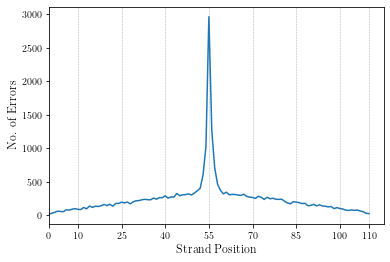

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov10-sab-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 6, 8, 16, 17, 11, 18, 19, 14, 20, 18, 18, 27, 13, 19, 21, 20, 25, 21, 28, 26, 23, 18, 25, 23, 27, 28, 21, 20, 30, 33, 21, 37, 32, 33, 32, 29, 30, 37, 26, 48, 34, 43, 25, 38, 26, 31, 36, 32, 28, 43, 40, 26, 36, 37, 112, 92, 44, 29, 28, 37, 37, 30, 42, 35, 36, 31, 40, 28, 35, 31, 31, 31, 30, 35, 22, 30, 34, 29, 30, 40, 32, 21, 21, 26, 32, 30, 28, 36, 24, 23, 24, 19, 26, 15, 11, 17, 19, 16, 18, 16, 20, 17, 15, 13, 17, 19, 7, 14, 7, 10]
[0, 10, 6, 9, 8, 10, 9, 9, 19, 13, 12, 7, 18, 9, 20, 20, 17, 21, 12, 11, 15, 26, 16, 21, 24, 26, 16, 22, 15, 16, 22, 23, 29, 35, 18, 23, 31, 25, 24, 23, 34, 32, 27, 21, 28, 17, 30, 27, 33, 24, 23, 26, 32, 27, 41, 92, 97, 41, 23, 21, 20, 30, 26, 22, 25, 29, 37, 25, 26, 22, 21, 25, 21, 22, 14, 23, 25, 31, 22, 21, 29, 16, 17, 16, 19, 26, 23, 19, 13, 10, 19, 18, 23, 13, 20, 28, 19, 16, 11, 13, 11, 12, 6, 10, 14, 6, 14, 13, 7, 4, 3]
[0, 2, 4, 5, 7, 4, 11, 6, 12, 10, 9, 8, 7, 8, 7, 5, 12, 12, 16, 17, 9, 14, 8, 19, 13, 18, 11, 19, 16, 16, 18, 24, 13, 19, 19, 2

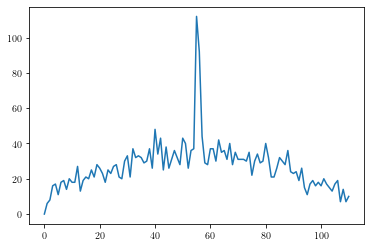

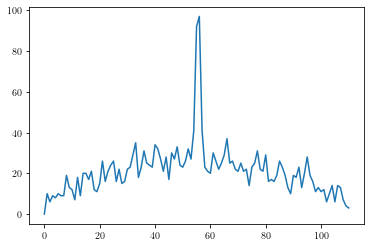

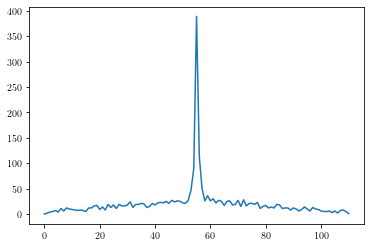

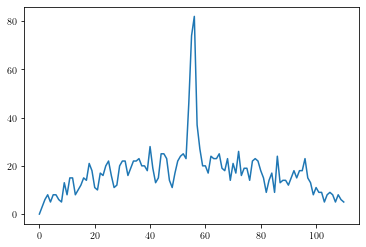

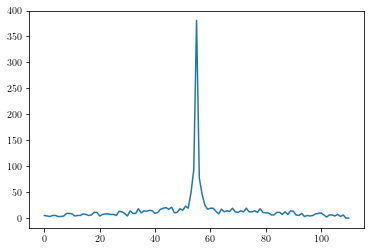

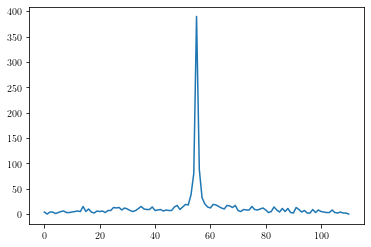

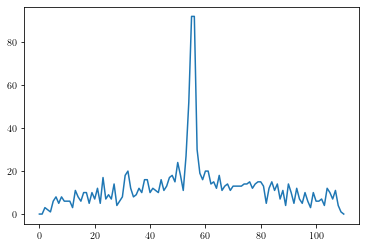

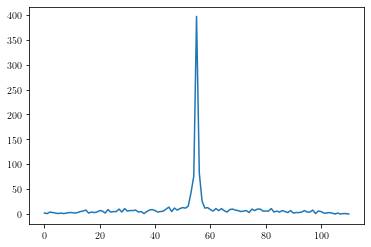

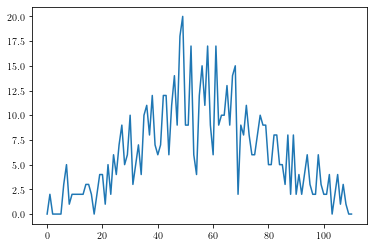

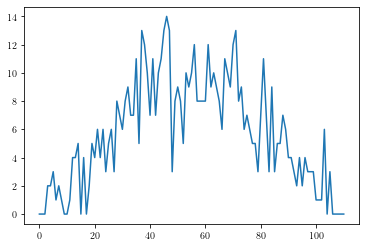

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)